# torchsummary doesn't work for rnns - this is a known issue 

Issues with the below:

I had to hack it so that it would reduce the frequencies dimension and not the time one by swapping indexies - this doesn't seem to be a very desirable solution.     

I think I need to be more careful about the set up of the neural network. 

In [1]:
'''
Main training file

'''
import torch
#hyper parameters 
import torch.optim as optim
from model import get_accuracy
from model import *
from data_loading import resize_label
from data_loading import *
from torch.utils.data import DataLoader
from torchsummary import summary

epochs = 53
cutoff = 0.1 # using a really low one 
lr =0.01
batch_size = 4

#spectrogram parameters
spec_freq = 101
spec_time = 1375
#label time
label_time = 1375




#### Load data 

test_waveform = ReadData('test',spectrogram_str='False')
test = ReadData('test',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)
train = ReadData('train',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)

train_loader = DataLoader(train, batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size, shuffle=False)


#### Initialise model

# import the model and initialise 
#load in to know the size of the spectrogram - the fft does quite give you a spec_time length for the time dimension
spec_wave = test[-1][0]
spec_label = test[-1][1]



input_freq =spec_wave.shape[1]
input_time = spec_wave.shape[2]
output_time = label_time
hidden_time = output_time #could change this down the line 


model = SimpleRNN(time = input_freq,dropout_rate=0.5)

#model.Conv
# print(f"input shape: (1,{input_freq},{input_time})")  
# summary(model, (input_freq,input_time))     

#### Choose optimizers
criterion = torch.nn.BCELoss()

#alternate optmizer + scheduler - from guidance from https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/
optimizer = optim.AdamW(model.parameters(), lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=lr,
	steps_per_epoch=int(len(train)),
	epochs=epochs,
	anneal_strategy='linear')

# from torch.optim.lr_scheduler import ExponentialLR 
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
#torch.optim.SGD(model.parameters(), lr=lr) # doesnot work




In [2]:

##### Training step

trainloader = train
N_trainloader = len(trainloader)

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    running_av_label = 0.0 
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs2, labels_og = data
        
        labels =  resize_label(labels_og, input_time)
        
        inputs = inputs2.reshape((1,input_time,-1))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += get_accuracy(labels, outputs,cutoff=cutoff)
        running_av_label += torch.mean(labels)
        # if i % 4 == 3:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
        #     running_loss = 0.0
    
    
    print(f'Epoch [{epoch + 1}] loss: {loss}, learning rate {scheduler.get_lr()}, training accuracy cutoff ({cutoff}): {running_accuracy/N_trainloader}, average label {running_av_label/N_trainloader}')
    scheduler.step()
    

print('Finished Training')

### Save model
torch.save(model, 'model_test')




C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torch\optim\lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1] loss: 0.6567956209182739, learning rate [0.0004], training accuracy cutoff (0.1): 0.054554865424430644, average label 0.05455486848950386
Epoch [2] loss: 0.6211246848106384, learning rate [0.0004433212996389892], training accuracy cutoff (0.1): 0.054554865424430644, average label 0.05455486848950386
Epoch [3] loss: 0.5570266246795654, learning rate [0.0004866425992779784], training accuracy cutoff (0.1): 0.054554865424430644, average label 0.05455486848950386
Epoch [4] loss: 0.44392457604408264, learning rate [0.0005299638989169676], training accuracy cutoff (0.1): 0.054761904761904755, average label 0.05455486848950386
Epoch [5] loss: 0.38727355003356934, learning rate [0.0005732851985559567], training accuracy cutoff (0.1): 0.22950310559006207, average label 0.05455486848950386
Epoch [6] loss: 0.47620779275894165, learning rate [0.0006166064981949459], training accuracy cutoff (0.1): 0.7638716356107661, average label 0.05455486848950386
Epoch [7] loss: 0.44359710812568665, 

RuntimeError: Given normalized_shape=[101], expected input with shape [*, 101], but got input of size[1, 101, 1380]

1.0


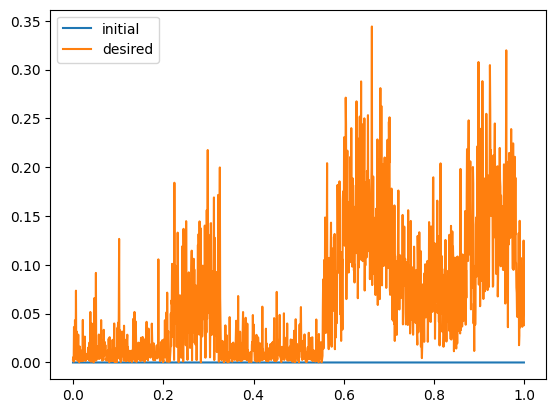

1.0


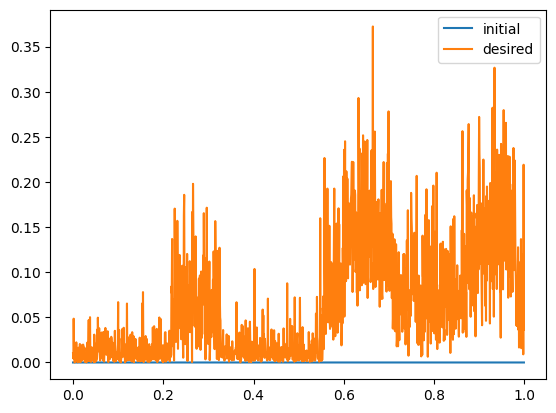

1.0


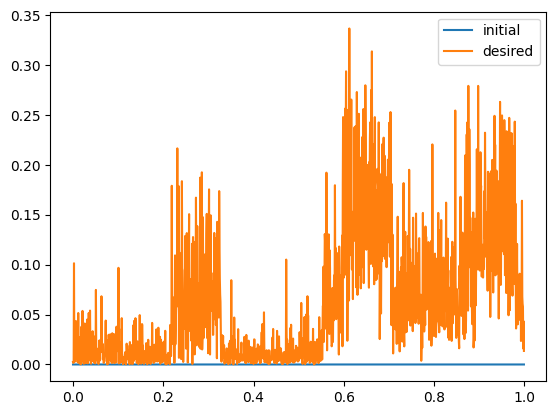

0.8905797101449275


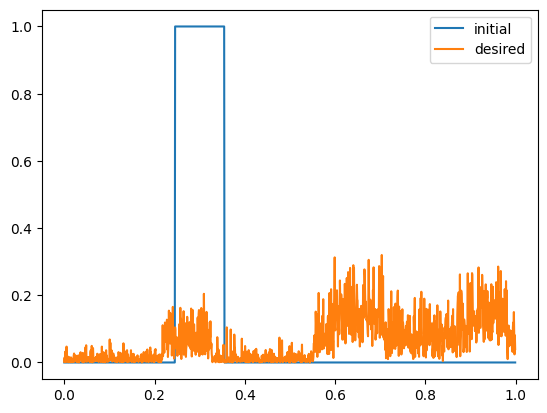

0.8905797101449275


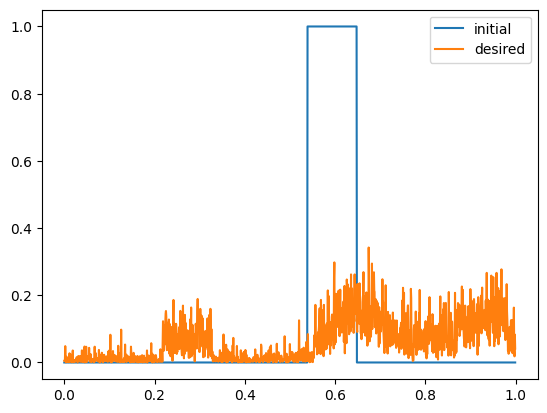

0.8905797101449275


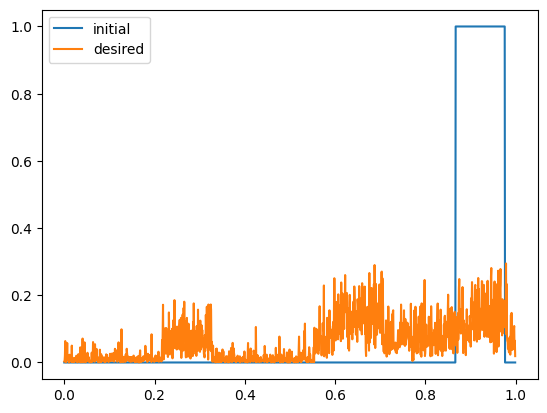

1.0 tensor(0.)
1.0 tensor(0.)
1.0 tensor(0.)
0.8909090909090909 tensor(10.9091)
0.8909090909090909 tensor(10.9091)
0.8909090909090909 tensor(10.9091)
average accuracy if the model returns a torch.zeros
0.9454545454545453
average loss  if the model returns a torch.zeros
tensor(5.4545)


In [3]:

##### Print accuracy for each part of the test data

# test on test data
testloader = test
for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs2, labels_og = data

    inputs = inputs2.reshape((1,input_time,-1))
    labels =  resize_label(labels_og, input_time)
    
    out = model(inputs)
    
    print(get_accuracy(labels, out,cutoff=0.8))
    
    #plot 
    plot_new_vs_old_label(labels,out.detach().numpy())
    
    

    
#### Example accuracy 
#Note by settign every label = torch.zeros we can get an accuracy out of 0.945
# just to note 
criterion = torch.nn.BCELoss()
acc_total = 0.0
loss_total = 0.0
for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels_og = data

    labels =  resize_label(labels_og, label_time)
    
    out = torch.zeros([1,labels.shape[1]])
    
    acc = get_accuracy(labels, out,cutoff=0.8)
    loss = criterion(out,labels)
    print(acc,loss)
    loss_total += loss
    acc_total += acc
print('average accuracy if the model returns a torch.zeros')
print(acc_total/(i+1))
print('average loss  if the model returns a torch.zeros')
print(loss_total/(i+1))
    

In [48]:
(inputs2, labels_og) = trainloader[0]

labels =  resize_label(labels_og, label_time)

inputs = inputs2.reshape((1,input_time,-1))

In [55]:
label_time

1375

tensor([[-0.0551, -0.0457, -0.0560,  ..., -0.0519, -0.0338, -0.0517]],
       grad_fn=<ReshapeAliasBackward0>)

In [37]:
print(1,input_time,input_freq)

1 1380 101


In [41]:
print(inputs.shape)

model = SimpleRNN(time = input_freq,dropout_rate=0.5)

inputs2 = inputs.reshape((1,input_freq,-1))

inputs2.shape
print(model(inputs2).shape)

torch.Size([1, 101, 1380])


RuntimeError: Given normalized_shape=[101], expected input with shape [*, 101], but got input of size[1, 101, 1380]

In [28]:
model

SimpleRNN(
  (rnn): LSTM(1380, 2760)
  (classifier): Sequential(
    (0): Linear(in_features=2760, out_features=1380, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1380, out_features=690, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=690, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_norm): LayerNorm((1380,), eps=1e-05, elementwise_affine=True)
)

In [27]:
print(outputs.shape,labels.shape)

torch.Size([1, 101]) torch.Size([1, 1375])


In [4]:
model(torch.zeros(1,101,1375))

RuntimeError: Given normalized_shape=[5518], expected input with shape [*, 5518], but got input of size[1, 101, 1375]